### Import Packages

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
import librosa
import librosa.display
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pydub import AudioSegment
from pydub.playback import play

In [5]:
import IPython.display as ipd


### Custom Functions

#### Get Chroma Features

In [6]:
def get_chroma_features(sound_window = [], plot=True):
    
    # rename window
    y = sound_window
    
    # Compute chroma features from the harmonic signal
    chroma_cq = librosa.feature.chroma_cqt(y=y,
                                       sr=22050, hop_length= 256)
    
    if plot == True:
        
        librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
        plt.title('chroma_cqt')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        for pitch_class in range(0,12):

            title_str = "Pitch Class: " + str(pitch_class)
            plt.figure(figsize=(17,5))
            plt.title(title_str)
            plt.plot(chroma_cq[pitch_class,:])
            plt.show()
    
    df1 = pd.DataFrame(chroma_cq).T.add_prefix('pitch_')
    
    return df1

#### Get Melspectrogram features

In [7]:
def get_mel_spectrogram_features(sound_window = [], plot= True):
    
    # rename window
    y = sound_window
    
    mel_spec = librosa.feature.melspectrogram(y=y, sr=22050)
    
    if plot == True:
        
        librosa.display.specshow(mel_spec, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')
        plt.tight_layout()
        plt.show()

        for freq in range(0,128):

            title_str = "Mel Class: " + str(freq)
            plt.figure(figsize=(17,5))
            plt.title(title_str)
            plt.plot(mel_spec[freq,:])
            plt.show()
    
    df1 = round(pd.DataFrame(mel_spec).T.add_prefix('mel_'),6)
    
    df2 = df1[['mel_0', 'mel_1', 'mel_2', 'mel_3', 'mel_4', 'mel_5', 'mel_6', 'mel_7',
       'mel_8', 'mel_9', 'mel_10', 'mel_11', 'mel_12', 'mel_13', 'mel_14',
       'mel_15', 'mel_16', 'mel_17', 'mel_18', 'mel_19', 'mel_20', 'mel_21',
       'mel_22', 'mel_23', 'mel_24', 'mel_25', 'mel_26', 'mel_27', 'mel_28',
       'mel_29', 'mel_30', 'mel_31', 'mel_32', 'mel_33', 'mel_34', 'mel_35',
       'mel_36', 'mel_37', 'mel_38', 'mel_39', 'mel_40', 'mel_41', 'mel_42',
       'mel_43', 'mel_44', 'mel_45', 'mel_46', 'mel_47', 'mel_48', 'mel_49',
       'mel_50', 'mel_51', 'mel_52', 'mel_53', 'mel_54', 'mel_55', 'mel_56',
       'mel_57', 'mel_58', 'mel_59', 'mel_60', 'mel_61', 'mel_62', 'mel_63',
       'mel_64', 'mel_65', 'mel_66', 'mel_67', 'mel_68', 'mel_69', 'mel_70',
       'mel_71', 'mel_72', 'mel_73', 'mel_74', 'mel_75', 'mel_76', 'mel_77',
       'mel_78', 'mel_79', 'mel_80', 'mel_81', 'mel_82', 'mel_83', 'mel_84',
       'mel_85', 'mel_86', 'mel_87', 'mel_88', 'mel_89', 'mel_90', 'mel_91',
       'mel_92', 'mel_93', 'mel_94', 'mel_95', 'mel_96', 'mel_97']]
    
    
    return df2

In [8]:
# target_audio, target_sr = librosa.load('Voice_042.wav')
# len(target_audio)
# yt, index = librosa.effects.trim(target_audio, top_db=40)
# len(yt)
# mf_table = get_mel_spectrogram_features(sound_window = yt, plot= False)
# mf_table.describe().T.sort_values(by='50%', ascending=False)
# mf_table.describe().T.loc[~(mf_table.describe().T['50%'] == 0)].index

#### Get Zero Crossing Rate

In [9]:
def get_zero_crossing_rate(sound_window = [], plot=True):
    
    # rename window
    y = sound_window
    
    cross_rate = librosa.feature.zero_crossing_rate(y=y)
    
    if plot == True:
        title_str = "Zero Crossing Rate"
        plt.figure(figsize=(17,5))
        plt.title(title_str)
        plt.plot(cross_rate[0,:])
        plt.show()
    
    df1 = pd.DataFrame(cross_rate).T.rename(columns={0:'Zero_Cross_Rate'})
    
    return df1

#### Get Selected Features

In [10]:
def get_features(sound_window = [], feature_name = 'chroma'):
    
    if feature_name == 'chroma':
        # get chroma features
        feature_df = get_chroma_features(sound_window = sound_window, plot=False)
        
    elif feature_name == 'melspec':
        # get mel spectrogram features
        feature_df = get_mel_spectrogram_features(sound_window = sound_window, plot=False)
    
    elif feature_name == 'zerocross':
        # get zero crossing rate
        feature_df = get_zero_crossing_rate(sound_window = sound_window, plot=False)
    
    # merge the dataframe
#     comb_df1 = pd.merge(chroma_cq_df, mel_spec_df, left_index= True, right_index=True, how='inner')
#     comb_df2 = pd.merge(comb_df1, zero_cross_df, left_index= True, right_index=True, how='inner')
    
#     print(comb_df2.shape)
    
    return feature_df

#### Compare Features

In [11]:
def compare_features(test_audio = [], target_audio = [], feature_name='melspec', plot=True):
    start_time_seconds = time.time()

    window_size = len(target_audio)
    #obj = Input_audios.objects.last()
    wsize = 1500
    rmse_holder = []
    max_error_holder = []
    sample_holder = []
    # get features for the target audio
    feature_target = get_features(sound_window = target_audio, feature_name= feature_name)

    #for i in range(0, len(test_audio), window_size):
    for i in range(0, len(test_audio), wsize):

        test_set = test_audio[i:i+window_size]

        if len(test_set) == window_size:

            feature_test = get_features(sound_window = test_set, feature_name= feature_name)

            # calculate the rmse
            rmse = mean_squared_error(feature_target, feature_test, squared=False)
            rmse_holder.append(rmse)
            # calculate the max error score - on raw audio itself
            max_error_val = max_error(target_audio, test_set)
            max_error_holder.append(max_error_val)
            # append the sample holder
            sample_holder.append(i)

        elif len(test_set) < window_size:

            last_test_set = test_audio[-window_size:]

            feature_test = get_features(sound_window = last_test_set, feature_name= feature_name)

            # calculate the rmse
            rmse = mean_squared_error(feature_target, feature_test, squared=False)
            rmse_holder.append(rmse)
            # calculate the max error score - on raw audio itself
            max_error_val = max_error(target_audio, last_test_set)
            max_error_holder.append(max_error_val)
            # append the sample holder
            sample_holder.append(i)


    if plot == True:
        plt.figure(figsize=(17,5))
        plt.title('RMSE Graph')
        plt.plot(rmse_holder, color='teal');
        plt.show()
        plt.figure(figsize=(17,5))
        plt.title('Max Error Graph')
        plt.plot(max_error_holder, color='darkgoldenrod');
        plt.show()

    result_df = pd.DataFrame({'sample_loc': sample_holder, 'rmse': rmse_holder, 'max_error': max_error_holder})

    stop_time_seconds = time.time()
    runtime = round((stop_time_seconds - start_time_seconds),2)
    print('The feature extraction and comparison runtime of ', feature_name, ' is: ', runtime, ' seconds')
    return result_df, runtime

#### Define Cost Function

In [12]:
def cost_function(featureList=['melspec', 'chroma', 'zerocross'], coefficientValues= [0.9, 0.9, 0.8],
                  target_audio = [], test_audio=[], plot=True):
    
    # TODO -- iterate over the feature list and add results in the placeholder
    
    # when the feature name is melspec
    result_melspec, runtime_melspec = compare_features(test_audio = test_audio, target_audio = target_audio,
                                                       feature_name='melspec', plot=False)
    # when the feature name is melspec
    result_chroma, runtime_chroma = compare_features(test_audio = test_audio, target_audio = target_audio,
                                                       feature_name='chroma', plot=False)
    # when the feature name is melspec
    result_zerocross, runtime_zerocross = compare_features(test_audio = test_audio, target_audio = target_audio,
                                                       feature_name='zerocross', plot=False)
    
    # set index of result df at sample loc
    result_melspec2 = result_melspec.set_index('sample_loc')
    result_chroma2 = result_chroma.set_index('sample_loc')
    result_zerocross2 = result_zerocross.set_index('sample_loc')
    
    # set coefficients for each
    agg_df = result_melspec2 * coefficientValues[0] + result_chroma2 * coefficientValues[1] + \
                result_zerocross2 * coefficientValues[2]
    
    avg_df = agg_df / len(featureList)
    
    
    if plot == True:
        plt.figure(figsize=(17,5))
        plt.title('RMSE Graph')
        plt.plot(avg_df['rmse'], color='teal');
        plt.show()
        plt.figure(figsize=(17,5))
        plt.title('Max Error Graph')
        plt.plot(avg_df['max_error'], color='darkgoldenrod');
        plt.show()
    
    return avg_df

#### Evaluate Comparison

In [13]:
def evaluate_comparison(result_df = pd.DataFrame(), rmse_threshold = 10, max_error_threshold = 0.20):
    
    result_df = result_df.reset_index()
    # sort the result with min rmse and max error
    sorted_df = result_df.sort_values(by=['rmse', 'max_error'], ascending=[True, True])
    
    # find the sample loc of the min rmse and min of max error
    start_loc = sorted_df['sample_loc'].iloc[0]
    selected_rmse = sorted_df['rmse'].iloc[0]
    selected_max_error = sorted_df['max_error'].iloc[0]
    
    
    # if the rmse and max error are below certain threshold
    if (selected_rmse < rmse_threshold) and (selected_max_error < max_error_threshold):
    
        # Print
        print('The target audio clip has potentially been found')
        print('The target audio starts at: ', start_loc, ' sample')
        print('The RMSE of the sample is : ', selected_rmse)
        print('The Max Error of the sample is : ', selected_max_error)
        
    else:
        print('The target audio clip could not be found')
        
    return sorted_df

#### Boundary Setter

In [14]:
def trim_resample_average(sample_1_file='abc.wav', sample_2_file='def.wav', sample_3_file='ghi.wav'):
    
    # read the file and get timeseries
    raw_y1, sr1 = librosa.load(sample_1_file, sr= 22050)
    raw_y2, sr2 = librosa.load(sample_2_file, sr= 22050)
    raw_y3, sr3 = librosa.load(sample_3_file, sr= 22050)
    
    # trim the start and end silence
    y1, index1 = librosa.effects.trim(raw_y1, top_db=35)
    y2, index2 = librosa.effects.trim(raw_y2, top_db=35)
    y3, index3 = librosa.effects.trim(raw_y3, top_db=35)
    
    # calculate the mean length of the time series
    avg_length = np.mean([len(y1), len(y2), len(y3)])
    
    # determine the new sampling rate adjusted for the average length
    time_duration_1 = len(y1) / sr1
    new_sr1 = avg_length / time_duration_1
    
    time_duration_2 = len(y2) / sr2
    new_sr2 = avg_length / time_duration_2
    
    time_duration_3 = len(y3) / sr3
    new_sr3 = avg_length / time_duration_3
    
    # resample the audio signals with new sampling rate
    adj_y1 = librosa.resample(y1, sr1, new_sr1)
    adj_y2 = librosa.resample(y2, sr2, new_sr2)
    adj_y3 = librosa.resample(y3, sr3, new_sr3)
    
    # calculate the mean of the adjusted sampling rate
    mean_new_sr = np.mean([new_sr1, new_sr2, new_sr3])
    
    # calculate the mean of three audio time series
    mean_new_y = np.mean([adj_y1, adj_y2, adj_y3], axis=0)
    
    # return mean y and mean sr
    return mean_new_y, mean_new_sr
    

#### Write Output

In [15]:
def write_audio_output(potential_df = pd.DataFrame(), target_length = 10.0, test_audio=[], test_sr=10.0):
    
    # convert the first search result into audio
    start_point = potential_df['sample_loc'].iloc[0]
    end_point = start_point + target_length
    audio_subset = test_audio[start_point: end_point]
    librosa.output.write_wav('search_1.wav', audio_subset, sr=test_sr)
    
    # convert the second search result into audio
    start_point = potential_df['sample_loc'].iloc[1]
    end_point = start_point + target_length
    audio_subset = test_audio[start_point: end_point]
    librosa.output.write_wav('search_2.wav', audio_subset, sr=test_sr)
    
    # convert the third search result into audio
    start_point = potential_df['sample_loc'].iloc[2]
    end_point = start_point + target_length
    audio_subset = test_audio[start_point: end_point]
    librosa.output.write_wav('search_3.wav', audio_subset, sr=test_sr)
    
#     # convert the fourth search result into audio
#     start_point = potential_df['sample_loc'].iloc[3]
#     end_point = start_point + target_length
#     audio_subset = test_audio[start_point: end_point]
#     librosa.output.write_wav('search_4.wav', audio_subset, sr=test_sr)
    
#     # convert the fifth search result into audio
#     start_point = potential_df['sample_loc'].iloc[4]
#     end_point = start_point + target_length
#     audio_subset = test_audio[start_point: end_point]
#     librosa.output.write_wav('search_5.wav', audio_subset, sr=test_sr)
    
#     # convert the fifth search result into audio
#     start_point = potential_df['sample_loc'].iloc[5]
#     end_point = start_point + target_length
#     audio_subset = test_audio[start_point: end_point]
#     librosa.output.write_wav('search_6.wav', audio_subset, sr=test_sr)
    
    

#### Search Function

In [16]:
def search_function(keyword_file1= 'abc.wav', keyword_file2='def.wav', keyword_file3 = 'ghi.wav',
                    large_audio_file='xyz.wav'):
    
    target_audio, target_sr = trim_resample_average(sample_1_file=keyword_file1,
                                                    sample_2_file=keyword_file2, sample_3_file=keyword_file3)
    
    
    target_audio, target_sr = librosa.load(keyword_file1, sr = 18000)
    
    target_audio, index = librosa.effects.trim(target_audio, top_db=15)
    
    print(len(target_audio))
    
    test_filename = large_audio_file
    
    test_audio, test_sr = librosa.load(test_filename, sr= target_sr)
    
    #test_audio, index = librosa.effects.trim(test_filename, top_db=15)
    
    print(len(test_audio))
    
    result = cost_function(featureList=['melspec', 'chroma', 'zerocross'],
                       coefficientValues= [0.2, 0.8, 1.0], 
                       target_audio = target_audio,
                        test_audio = test_audio,
#                       test_audio=test_audio[int(test_sr*2):-int(test_sr*2)],
                       plot=True)
    
    potential_df = evaluate_comparison(result_df = result, rmse_threshold = 7, max_error_threshold = 0.70)
    
    # store the output in audio form
    write_audio_output(potential_df = potential_df, target_length = len(target_audio),
                       test_audio=test_audio, test_sr=int(test_sr))
    
    return potential_df

19641
81917
The feature extraction and comparison runtime of  melspec  is:  1.41  seconds
The feature extraction and comparison runtime of  chroma  is:  1.68  seconds
The feature extraction and comparison runtime of  zerocross  is:  0.15  seconds


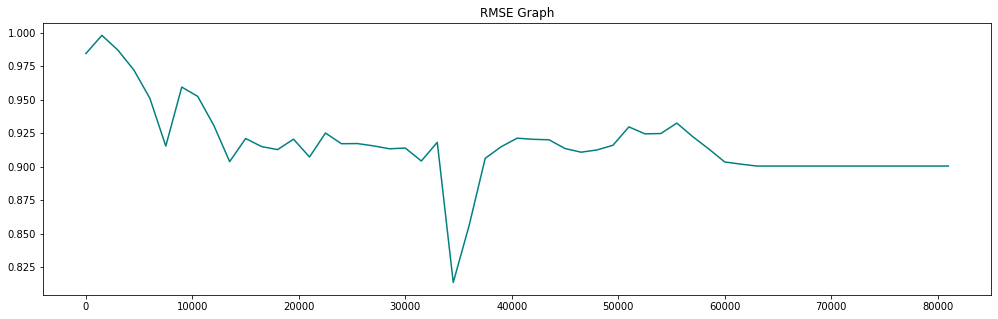

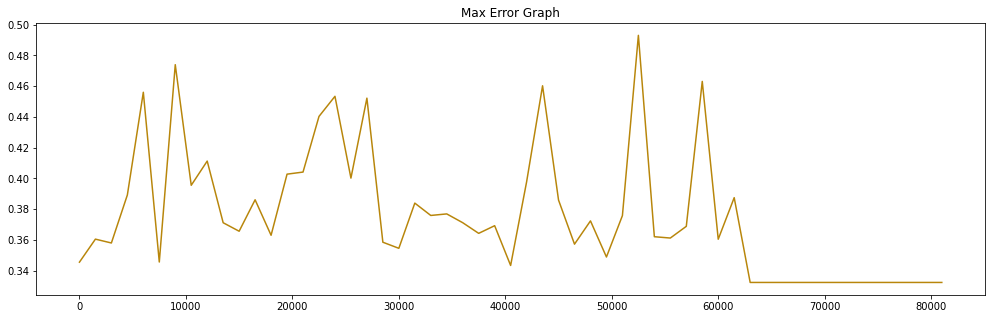

The target audio clip has potentially been found
The target audio starts at:  34500  sample
The RMSE of the sample is :  0.8135825269382989
The Max Error of the sample is :  0.3768581549326579
CPU times: user 8.3 s, sys: 668 ms, total: 8.97 s
Wall time: 4.66 s


In [17]:
%%time
potential_df = search_function(keyword_file1= 'hsbc.wav', keyword_file2='hsbc.wav', keyword_file3 = 'hsbc.wav',
                    large_audio_file='hsbc_long.wav')

In [18]:
potential_df.head()

,sample_loc,rmse,max_error
23,34500,0.813583,0.376858
24,36000,0.856301,0.371140
42,63000,0.900407,0.332278
43,64500,0.900407,0.332278
44,66000,0.900407,0.332278


In [21]:
ipd.Audio("hsbc.wav")

In [22]:
ipd.Audio("hsbc_long.wav")

In [23]:
ipd.Audio("search_1.wav")

In [24]:
ipd.Audio("search_2.wav")

In [59]:
ipd.Audio("search_3.wav")

In [ ]:
ipd.Audio("search_5.wav")

In [ ]:
ipd.Audio("search_6.wav")